In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor



df = joblib.load("/home/lavrenchuk/TS_Project_Favorita/data/processed/features_agg.joblib")
print(df.shape)
print(df.index.min(), df.index.max())
display(df.tail())

(1688, 27)
0 1687


,date,unit_sales,unit_sales_log,month,day_of_month,weekday,is_workday,lag_log_1,lag_log_7,lag_log_14,...,dow_sin,dow_cos,year_sin,year_cos,is_holiday,before_holiday,after_holiday,is_christmas,pre_christmas,post_christmas
1683,2017-08-11,80783.227,11.299537,8,11,4,1,10.984767,11.172635,11.192696,...,-0.433884,-0.900969,-0.866025,-0.5,0,0,1,0,0,0
1684,2017-08-12,77928.860,11.263564,8,12,5,0,11.299537,11.399004,11.469589,...,-0.974928,-0.222521,-0.866025,-0.5,0,0,0,0,0,0
1685,2017-08-13,92090.859,11.430542,8,13,6,0,11.263564,11.571467,11.615288,...,-0.781831,0.623490,-0.866025,-0.5,0,0,0,0,0,0
1686,2017-08-14,69852.929,11.154162,8,14,0,1,11.430542,11.195912,11.342291,...,0.000000,1.000000,-0.866025,-0.5,0,1,0,0,0,0
1687,2017-08-15,80080.046,11.290794,8,15,1,1,11.154162,11.110238,11.509225,...,0.781831,0.623490,-0.866025,-0.5,1,0,0,0,0,0


## Prophet (without holidays)

Test period: 2017-05-18 00:00:00 → 2017-08-15 00:00:00


06:05:05 - cmdstanpy - INFO - Chain [1] start processing
06:05:05 - cmdstanpy - INFO - Chain [1] done processing



Forecast 90 days (real sales):
           ds     yhat_real  yhat_lower_real  yhat_upper_real
0  2017-05-18  58140.698538     21485.379540    154976.098757
1  2017-05-19  63685.358201     25790.585549    156109.447767
2  2017-05-20  89732.586154     34800.817153    225763.796537
3  2017-05-21  88531.853592     35279.899590    224797.268910
4  2017-05-22  75216.556640     30104.950831    191279.417593
..        ...           ...              ...              ...
85 2017-08-11  69404.225586     27180.649235    175397.250398
86 2017-08-12  98871.506422     39611.419924    248019.191425
87 2017-08-13  98539.797561     40379.973146    244710.506863
88 2017-08-14  84468.683983     35628.861976    228075.558716
89 2017-08-15  79570.601319     32271.834823    207182.996379

[90 rows x 4 columns]


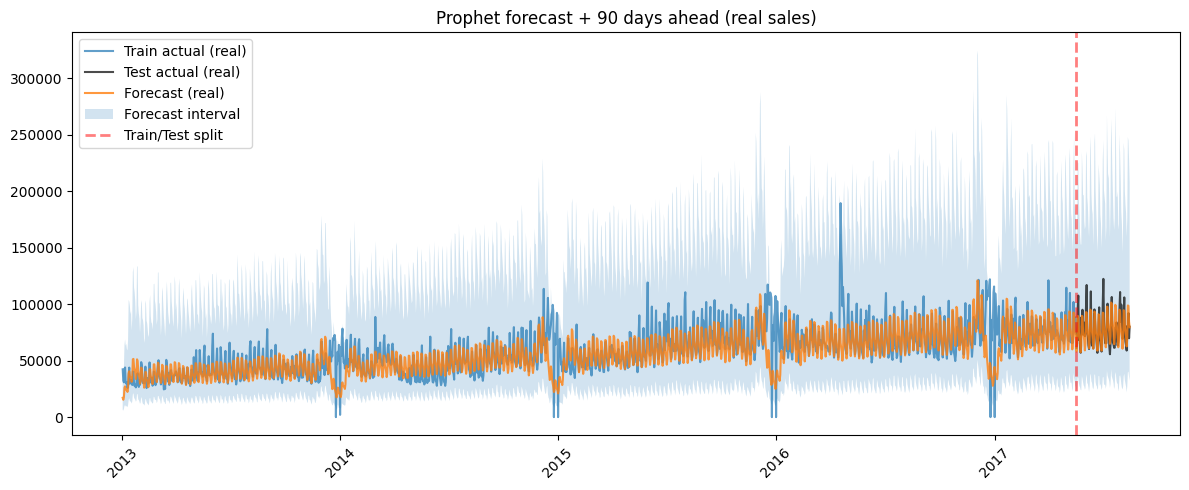

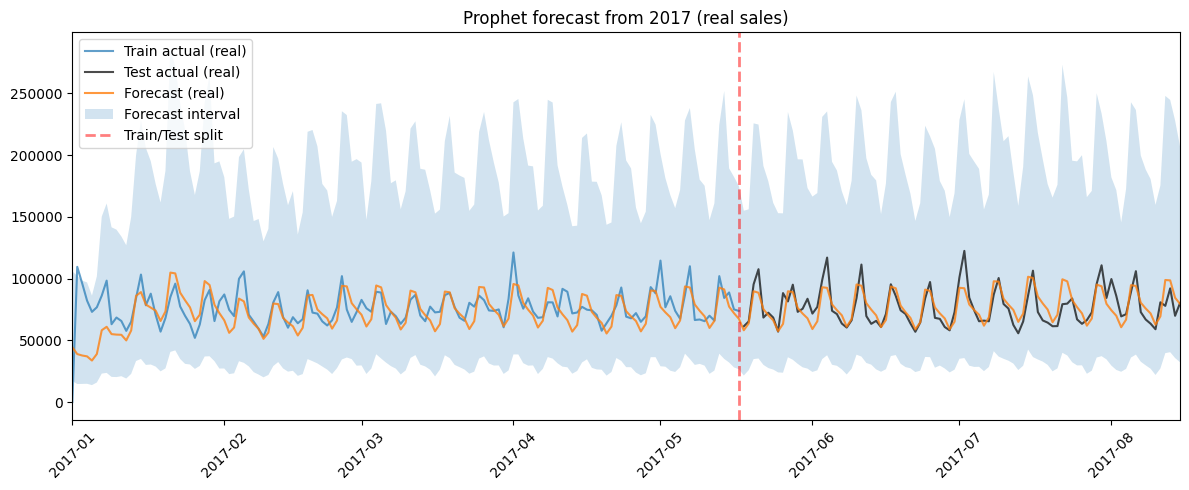


Test metrics:
MAE_30  = 7797.23
RMSE_30 = 10295.19
MAPE_30 = 9.36%

MAE_60  = 7057.22
RMSE_60 = 9426.20
MAPE_60 = 8.65%

MAE_90  = 7965.66
RMSE_90 = 10198.52
MAPE_90 = 9.99%


In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error


df_prophet = df.copy()

df_prophet = df_prophet.reset_index().rename(columns={
    'date': 'ds',          
    'unit_sales_log': 'y'  #будуємо на основі логарифму таргету
})

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Спліт на трейн/тест, тест на останніх 90 днях
train, test = df_prophet[:-90], df_prophet[-90:]
print("Test period:", test['ds'].min(), "→", test['ds'].max())

# Модель Prophet 
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)

model.fit(train)

# Прогноз на 90 днів 
future = model.make_future_dataframe(periods=90, freq='D')
forecast = model.predict(future)

# Перехід з логарифму до натуральних продажів для forecast
forecast['yhat_real'] = np.exp(forecast['yhat'])
forecast['yhat_lower_real'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_real'] = np.exp(forecast['yhat_upper'])

# Беремо тільки 90 майбутніх днів після train
forecast_90 = forecast.tail(90).reset_index(drop=True)
forecast_60 = forecast_90.iloc[:60]
forecast_30 = forecast_90.iloc[:30]

# Таблиці прогнозів у натуральних одиницях
print("\nForecast 90 days (real sales):")
print(forecast_90[['ds', 'yhat_real', 'yhat_lower_real', 'yhat_upper_real']])

# фактичні продажі у натуральних одиницях
train_real = train.copy()
test_real = test.copy()
train_real['y_real'] = np.exp(train_real['y'])
test_real['y_real'] = np.exp(test_real['y'])



# Графік прогнозу на весь період в натуральних одиницях
# Так як графік буде в натуральних одиницях, а таргет був логарифмом - прийдеться будувати вручну, а не через model.plot
plt.figure(figsize=(12, 5))

# історичні значення
plt.plot(train_real['ds'], train_real['y_real'],
         label='Train actual (real)', alpha=0.7)
plt.plot(test_real['ds'], test_real['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

# прогнозні значення
plt.plot(forecast['ds'], forecast['yhat_real'],
         label='Forecast (real)', alpha=0.8)

# довірчий інтервал
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower_real'],
    forecast['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

# межа між вибірками трейн і тест
plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.title('Prophet forecast + 90 days ahead (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



#Укрупнений графік, тільки з 2017 року
plt.figure(figsize=(12, 5))

mask_2017 = forecast['ds'] >= pd.Timestamp("2017-01-01")

plt.plot(train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Train actual (real)', alpha=0.7)

plt.plot(test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

plt.plot(forecast[mask_2017]['ds'],
         forecast[mask_2017]['yhat_real'],
         label='Forecast (real)', alpha=0.8)

plt.fill_between(
    forecast[mask_2017]['ds'],
    forecast[mask_2017]['yhat_lower_real'],
    forecast[mask_2017]['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.xlim(pd.Timestamp("2017-01-01"), forecast['ds'].max())
plt.title('Prophet forecast from 2017 (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Метрики в натуральному масштабі (на 90-денному тесті)

# привʼязуємо прогноз до тестових дат
forecast_test = forecast[forecast['ds'].isin(test['ds'])].copy()

df_eval = test[['ds', 'y']].merge(
    forecast_test[['ds', 'yhat']],
    on='ds',
    how='left'
)

# переходимо до натуральних одиниць
df_eval['y_real'] = np.exp(df_eval['y'])
df_eval['yhat_real'] = np.exp(df_eval['yhat'])

def metrics(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mae, rmse, mape

MAE_90, RMSE_90, MAPE_90 = metrics(df_eval['y_real'], df_eval['yhat_real'])
MAE_60, RMSE_60, MAPE_60 = metrics(df_eval['y_real'][:60], df_eval['yhat_real'][:60])
MAE_30, RMSE_30, MAPE_30 = metrics(df_eval['y_real'][:30], df_eval['yhat_real'][:30])

print("\nTest metrics:")
print(f"MAE_30  = {MAE_30:.2f}")
print(f"RMSE_30 = {RMSE_30:.2f}")
print(f"MAPE_30 = {MAPE_30:.2f}%")

print(f"\nMAE_60  = {MAE_60:.2f}")
print(f"RMSE_60 = {RMSE_60:.2f}")
print(f"MAPE_60 = {MAPE_60:.2f}%")

print(f"\nMAE_90  = {MAE_90:.2f}")
print(f"RMSE_90 = {RMSE_90:.2f}")
print(f"MAPE_90 = {MAPE_90:.2f}%")

## Prophet with holidays



             ds  holiday
1665 2017-07-24  holiday
1666 2017-07-25  holiday
1677 2017-08-05  holiday
1682 2017-08-10  holiday
1687 2017-08-15  holiday


06:05:06 - cmdstanpy - INFO - Chain [1] start processing
06:05:06 - cmdstanpy - INFO - Chain [1] done processing



Forecast 90 days (real sales):
           ds      yhat_real  yhat_lower_real  yhat_upper_real
0  2017-05-18   60824.687478     24056.983464    160466.510368
1  2017-05-19   66629.608686     26105.855569    159734.695116
2  2017-05-20   93057.530169     34547.304748    234033.127870
3  2017-05-21   91309.747604     35464.674574    226434.662349
4  2017-05-22   77993.580572     30602.719096    203389.986890
..        ...            ...              ...              ...
85 2017-08-11   73522.621325     29510.025370    169538.752130
86 2017-08-12  104071.757788     42204.610556    282727.935345
87 2017-08-13  103433.903514     42703.236675    272670.677825
88 2017-08-14   89399.014924     34064.572740    251430.272496
89 2017-08-15   61000.025697     25605.817792    156016.622197

[90 rows x 4 columns]


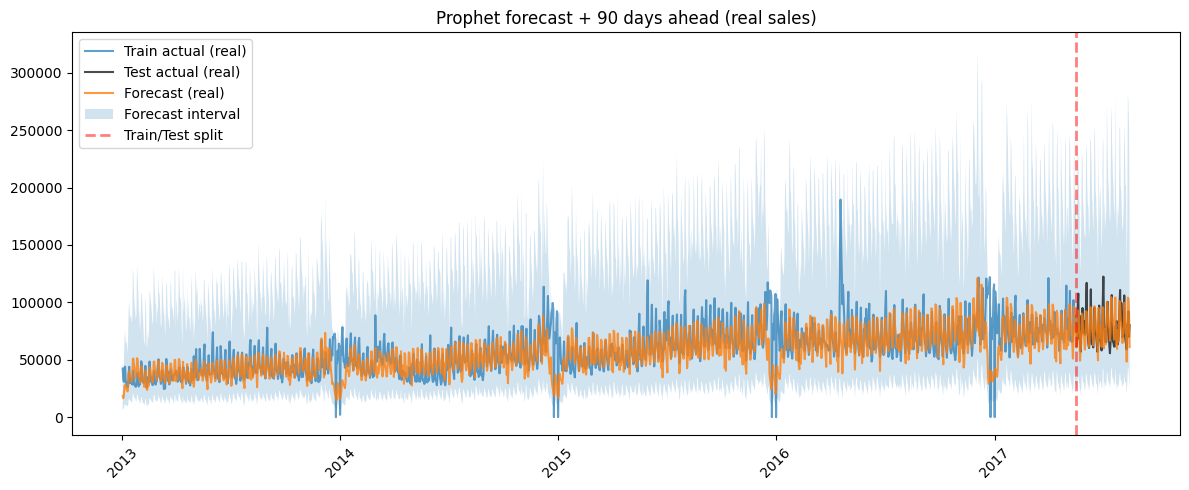

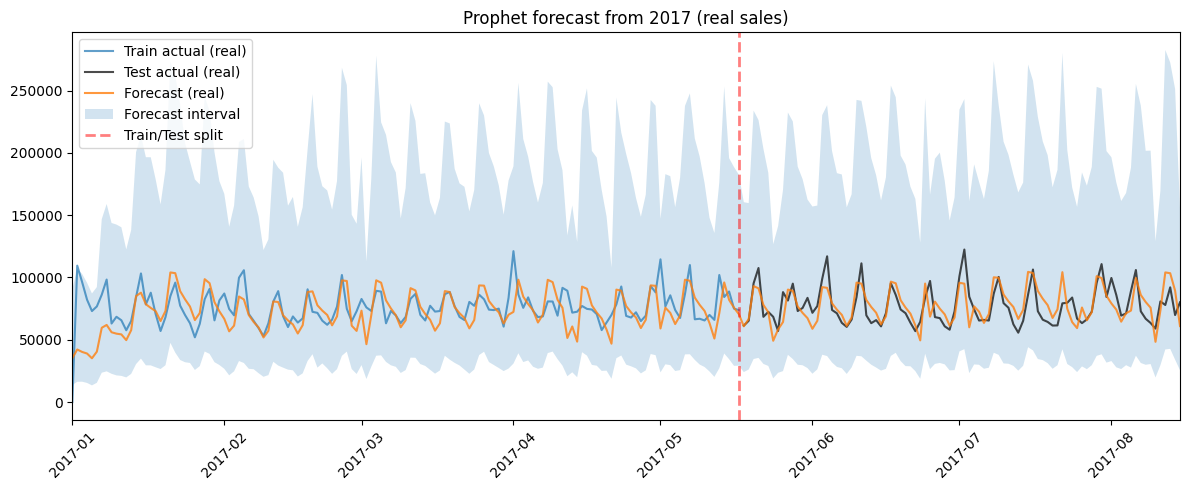


Test metrics:
MAE_30  = 8353.06
RMSE_30 = 10888.93
MAPE_30 = 10.27%

MAE_60  = 8880.65
RMSE_60 = 11370.28
MAPE_60 = 11.21%

MAE_90  = 9766.90
RMSE_90 = 12109.21
MAPE_90 = 12.56%


In [222]:
holidays_df = df_prophet.loc[df_prophet['is_holiday'] == 1, ['ds']].copy()
holidays_df['holiday'] = 'holiday'
print(holidays_df.tail())

# Модель Prophet зі святами
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    holidays=holidays_df
)

model.fit(train)

# Прогноз на 90 днів 
future = model.make_future_dataframe(periods=90, freq='D')
forecast = model.predict(future)

# Перехід з логарифму до натуральних продажів для forecast
forecast['yhat_real'] = np.exp(forecast['yhat'])
forecast['yhat_lower_real'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_real'] = np.exp(forecast['yhat_upper'])

# Беремо тільки 90 майбутніх днів після train
forecast_90 = forecast.tail(90).reset_index(drop=True)
forecast_60 = forecast_90.iloc[:60]
forecast_30 = forecast_90.iloc[:30]

# Таблиці прогнозів у натуральних одиницях
print("\nForecast 90 days (real sales):")
print(forecast_90[['ds', 'yhat_real', 'yhat_lower_real', 'yhat_upper_real']])

# фактичні продажі у натуральних одиницях
train_real = train.copy()
test_real = test.copy()
train_real['y_real'] = np.exp(train_real['y'])
test_real['y_real'] = np.exp(test_real['y'])



# Графік прогнозу на весь період в натуральних одиницях
plt.figure(figsize=(12, 5))

# історичні значення
plt.plot(train_real['ds'], train_real['y_real'],
         label='Train actual (real)', alpha=0.7)
plt.plot(test_real['ds'], test_real['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

# прогнозні значення
plt.plot(forecast['ds'], forecast['yhat_real'],
         label='Forecast (real)', alpha=0.8)

# довірчий інтервал
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower_real'],
    forecast['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

# межа між вибірками трейн і тест
plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.title('Prophet forecast + 90 days ahead (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



#Укрупнений графік, тільки з 2017 року
plt.figure(figsize=(12, 5))

mask_2017 = forecast['ds'] >= pd.Timestamp("2017-01-01")

plt.plot(train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Train actual (real)', alpha=0.7)

plt.plot(test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

plt.plot(forecast[mask_2017]['ds'],
         forecast[mask_2017]['yhat_real'],
         label='Forecast (real)', alpha=0.8)

plt.fill_between(
    forecast[mask_2017]['ds'],
    forecast[mask_2017]['yhat_lower_real'],
    forecast[mask_2017]['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.xlim(pd.Timestamp("2017-01-01"), forecast['ds'].max())
plt.title('Prophet forecast from 2017 (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Метрики в натуральному масштабі (на 90-денному тесті)

# привʼязуємо прогноз до тестових дат
forecast_test = forecast[forecast['ds'].isin(test['ds'])].copy()

df_eval = test[['ds', 'y']].merge(
    forecast_test[['ds', 'yhat']],
    on='ds',
    how='left'
)

# переходимо до натуральних одиниць
df_eval['y_real'] = np.exp(df_eval['y'])
df_eval['yhat_real'] = np.exp(df_eval['yhat'])

def metrics(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mae, rmse, mape

MAE_90, RMSE_90, MAPE_90 = metrics(df_eval['y_real'], df_eval['yhat_real'])
MAE_60, RMSE_60, MAPE_60 = metrics(df_eval['y_real'][:60], df_eval['yhat_real'][:60])
MAE_30, RMSE_30, MAPE_30 = metrics(df_eval['y_real'][:30], df_eval['yhat_real'][:30])

print("\nTest metrics:")
print(f"MAE_30  = {MAE_30:.2f}")
print(f"RMSE_30 = {RMSE_30:.2f}")
print(f"MAPE_30 = {MAPE_30:.2f}%")

print(f"\nMAE_60  = {MAE_60:.2f}")
print(f"RMSE_60 = {RMSE_60:.2f}")
print(f"MAPE_60 = {MAPE_60:.2f}%")

print(f"\nMAE_90  = {MAE_90:.2f}")
print(f"RMSE_90 = {RMSE_90:.2f}")
print(f"MAPE_90 = {MAPE_90:.2f}%")

Результат гірше за модель без змінної "свята", що дивно... можливо варто перевірити змінні before_holiday, after_holiday, можливо вони впливають більше.

## Prophet with before-, after-, holidays, but like tree additional regressors

06:05:07 - cmdstanpy - INFO - Chain [1] start processing
06:05:08 - cmdstanpy - INFO - Chain [1] done processing



Forecast 90 days (real sales):
           ds      yhat_real  yhat_lower_real  yhat_upper_real
0  2017-05-18   63956.676494     26669.347206    167528.488006
1  2017-05-19   69880.901961     26970.636847    164983.433652
2  2017-05-20   97464.470451     40620.273311    234512.478995
3  2017-05-21   95158.243814     38424.448127    237414.292245
4  2017-05-22   80422.391807     30576.735447    189947.947342
..        ...            ...              ...              ...
85 2017-08-11   57055.092187     22753.736832    147762.670508
86 2017-08-12  110504.684240     40649.727006    294731.665824
87 2017-08-13  109603.036670     46404.654863    268386.135962
88 2017-08-14   84228.389334     34031.888339    209870.322597
89 2017-08-15   69011.442598     27878.788584    173882.580099

[90 rows x 4 columns]


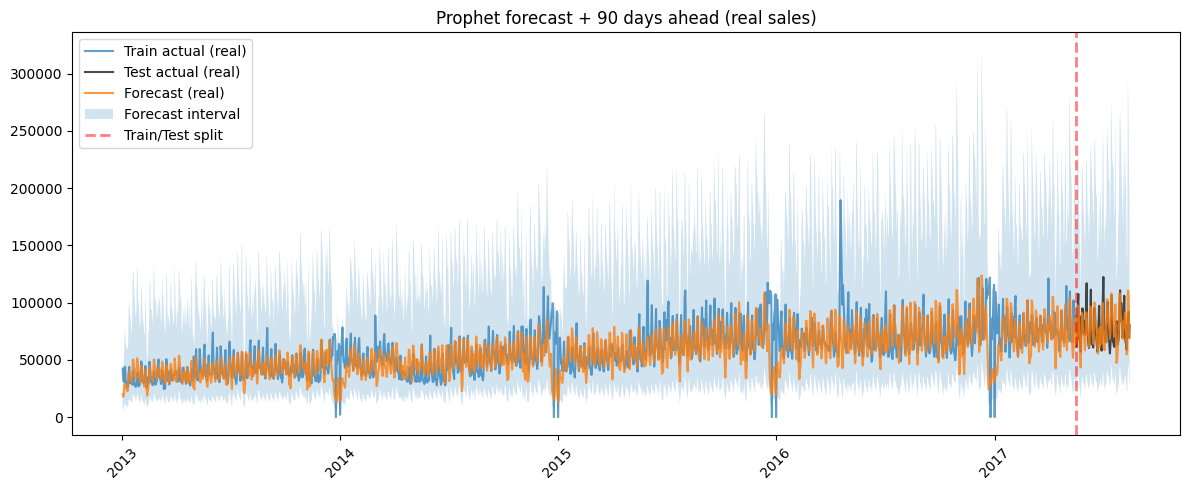

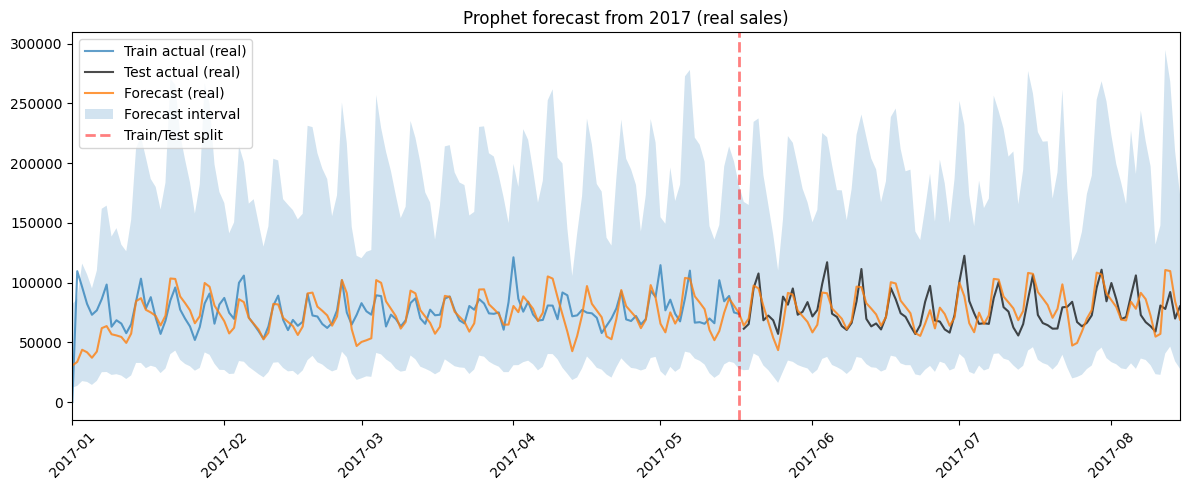


Test metrics:
MAE_30  = 9030.39
RMSE_30 = 11094.17
MAPE_30 = 11.47%

MAE_60  = 9835.36
RMSE_60 = 12046.17
MAPE_60 = 12.64%

MAE_90  = 11027.69
RMSE_90 = 13571.59
MAPE_90 = 14.27%


In [223]:

# Модель Prophet зі святами
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
)
model.add_regressor('before_holiday')
model.add_regressor('after_holiday')
model.add_regressor('is_holiday')
model.fit(train)

# Прогноз на 90 днів 
future = model.make_future_dataframe(periods=90, freq='D')
future = future.merge(
    df_prophet[['ds', 'before_holiday', 'after_holiday', 'is_holiday']],
    on='ds',
    how='left'
)

future[['before_holiday', 'after_holiday', 'is_holiday']] = future[['before_holiday', 'after_holiday', 'is_holiday']].fillna(0)
forecast = model.predict(future)

# Перехід з логарифму до натуральних продажів для forecast
forecast['yhat_real'] = np.exp(forecast['yhat'])
forecast['yhat_lower_real'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_real'] = np.exp(forecast['yhat_upper'])

# Беремо тільки 90 майбутніх днів після train
forecast_90 = forecast.tail(90).reset_index(drop=True)
forecast_60 = forecast_90.iloc[:60]
forecast_30 = forecast_90.iloc[:30]

# Таблиці прогнозів у натуральних одиницях
print("\nForecast 90 days (real sales):")
print(forecast_90[['ds', 'yhat_real', 'yhat_lower_real', 'yhat_upper_real']])

# фактичні продажі у натуральних одиницях
train_real = train.copy()
test_real = test.copy()
train_real['y_real'] = np.exp(train_real['y'])
test_real['y_real'] = np.exp(test_real['y'])



# Графік прогнозу на весь період в натуральних одиницях
plt.figure(figsize=(12, 5))

# історичні значення
plt.plot(train_real['ds'], train_real['y_real'],
         label='Train actual (real)', alpha=0.7)
plt.plot(test_real['ds'], test_real['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

# прогнозні значення
plt.plot(forecast['ds'], forecast['yhat_real'],
         label='Forecast (real)', alpha=0.8)

# довірчий інтервал
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower_real'],
    forecast['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

# межа між вибірками трейн і тест
plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.title('Prophet forecast + 90 days ahead (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



#Укрупнений графік, тільки з 2017 року
plt.figure(figsize=(12, 5))

mask_2017 = forecast['ds'] >= pd.Timestamp("2017-01-01")

plt.plot(train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Train actual (real)', alpha=0.7)

plt.plot(test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

plt.plot(forecast[mask_2017]['ds'],
         forecast[mask_2017]['yhat_real'],
         label='Forecast (real)', alpha=0.8)

plt.fill_between(
    forecast[mask_2017]['ds'],
    forecast[mask_2017]['yhat_lower_real'],
    forecast[mask_2017]['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.xlim(pd.Timestamp("2017-01-01"), forecast['ds'].max())
plt.title('Prophet forecast from 2017 (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Метрики в натуральному масштабі (на 90-денному тесті)

# привʼязуємо прогноз до тестових дат
forecast_test = forecast[forecast['ds'].isin(test['ds'])].copy()

df_eval = test[['ds', 'y']].merge(
    forecast_test[['ds', 'yhat']],
    on='ds',
    how='left'
)

# переходимо до натуральних одиниць
df_eval['y_real'] = np.exp(df_eval['y'])
df_eval['yhat_real'] = np.exp(df_eval['yhat'])

def metrics(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mae, rmse, mape

MAE_90, RMSE_90, MAPE_90 = metrics(df_eval['y_real'], df_eval['yhat_real'])
MAE_60, RMSE_60, MAPE_60 = metrics(df_eval['y_real'][:60], df_eval['yhat_real'][:60])
MAE_30, RMSE_30, MAPE_30 = metrics(df_eval['y_real'][:30], df_eval['yhat_real'][:30])

print("\nTest metrics:")
print(f"MAE_30  = {MAE_30:.2f}")
print(f"RMSE_30 = {RMSE_30:.2f}")
print(f"MAPE_30 = {MAPE_30:.2f}%")

print(f"\nMAE_60  = {MAE_60:.2f}")
print(f"RMSE_60 = {RMSE_60:.2f}")
print(f"MAPE_60 = {MAPE_60:.2f}%")

print(f"\nMAE_90  = {MAE_90:.2f}")
print(f"RMSE_90 = {RMSE_90:.2f}")
print(f"MAPE_90 = {MAPE_90:.2f}%")

Результат ще гірше... кумедно =) 

Можливо в тестовій виборці (90 днів) немає свят?

Можливо варто виділити окремі типи свят, а не додавати всі підряд. Наприклад - Різдво, Новий + дні напередодні і після. 

## Prophet with Сhristmas + pre-, post- Chrisrmas days

06:05:09 - cmdstanpy - INFO - Chain [1] start processing
06:05:09 - cmdstanpy - INFO - Chain [1] done processing



Forecast 90 days (real sales):
           ds     yhat_real  yhat_lower_real  yhat_upper_real
0  2017-05-18  59978.969893     32288.748117    110914.100198
1  2017-05-19  65868.743539     35671.732845    129068.583686
2  2017-05-20  88575.201992     45127.708592    176048.615393
3  2017-05-21  91819.383875     50539.589858    175579.307091
4  2017-05-22  74053.649960     38954.902926    134943.845624
..        ...           ...              ...              ...
85 2017-08-11  69056.712624     35408.187266    130544.827519
86 2017-08-12  93476.646119     51042.895460    175097.523010
87 2017-08-13  97574.767994     48864.619070    190029.642441
88 2017-08-14  79253.526634     39985.100301    147163.549955
89 2017-08-15  74700.782676     37690.110261    141125.294366

[90 rows x 4 columns]


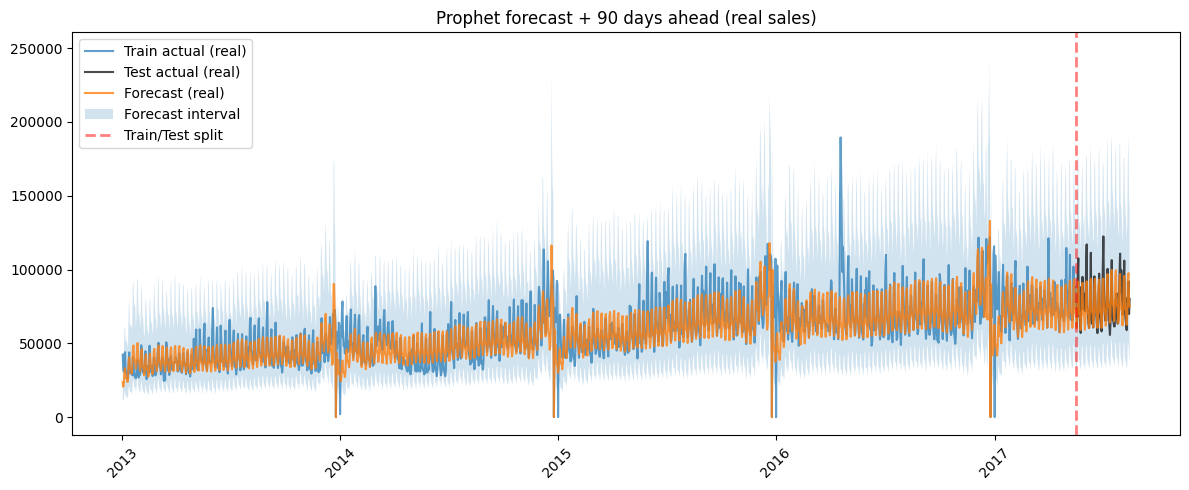

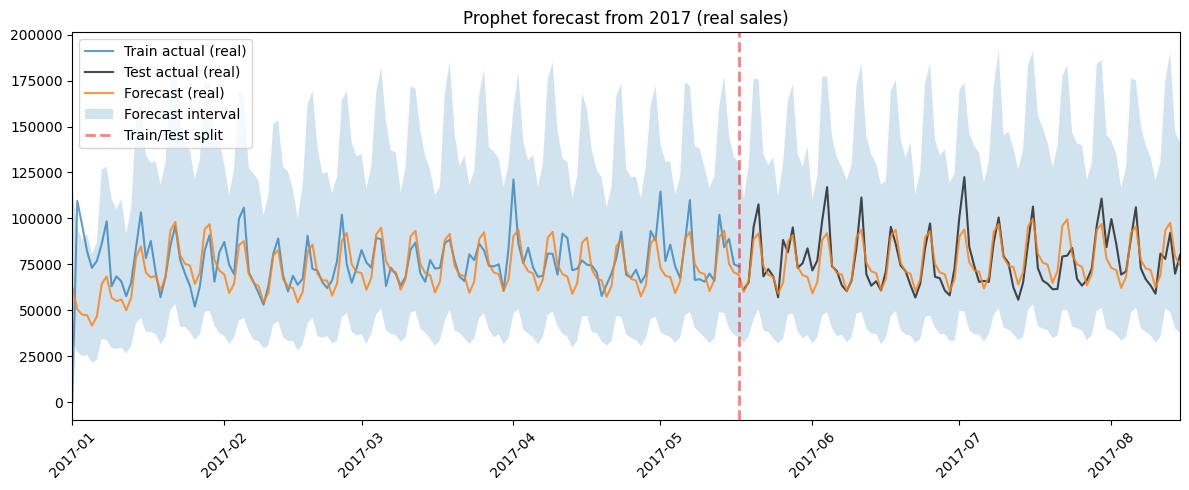


Test metrics:
MAE_30  = 6848.67
RMSE_30 = 9616.00
MAPE_30 = 8.03%

MAE_60  = 6417.33
RMSE_60 = 8777.15
MAPE_60 = 7.81%

MAE_90  = 7184.75
RMSE_90 = 9338.86
MAPE_90 = 8.95%


In [224]:
# Модель Prophet зі святами
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
)
model.add_regressor('is_christmas') 
model.add_regressor('pre_christmas')
model.add_regressor('post_christmas')
model.fit(train)

# Прогноз на 90 днів 
future = model.make_future_dataframe(periods=90, freq='D')
future = future.merge(
    df_prophet[['ds', 'is_christmas', 'pre_christmas', 'post_christmas']],
    on='ds',
    how='left'
)

future[['is_christmas', 'pre_christmas', 'post_christmas']] = future[['is_christmas', 'pre_christmas', 'post_christmas']].fillna(0)
forecast = model.predict(future)

# Перехід з логарифму до натуральних продажів для forecast
forecast['yhat_real'] = np.exp(forecast['yhat'])
forecast['yhat_lower_real'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_real'] = np.exp(forecast['yhat_upper'])

# Беремо тільки 90 майбутніх днів після train
forecast_90 = forecast.tail(90).reset_index(drop=True)
forecast_60 = forecast_90.iloc[:60]
forecast_30 = forecast_90.iloc[:30]

# Таблиці прогнозів у натуральних одиницях
print("\nForecast 90 days (real sales):")
print(forecast_90[['ds', 'yhat_real', 'yhat_lower_real', 'yhat_upper_real']])

# фактичні продажі у натуральних одиницях
train_real = train.copy()
test_real = test.copy()
train_real['y_real'] = np.exp(train_real['y'])
test_real['y_real'] = np.exp(test_real['y'])



# Графік прогнозу на весь період в натуральних одиницях
plt.figure(figsize=(12, 5))

# історичні значення
plt.plot(train_real['ds'], train_real['y_real'],
         label='Train actual (real)', alpha=0.7)
plt.plot(test_real['ds'], test_real['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

# прогнозні значення
plt.plot(forecast['ds'], forecast['yhat_real'],
         label='Forecast (real)', alpha=0.8)

# довірчий інтервал
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower_real'],
    forecast['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

# межа між вибірками трейн і тест
plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.title('Prophet forecast + 90 days ahead (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



#Укрупнений графік, тільки з 2017 року
plt.figure(figsize=(12, 5))

mask_2017 = forecast['ds'] >= pd.Timestamp("2017-01-01")

plt.plot(train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Train actual (real)', alpha=0.7)

plt.plot(test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

plt.plot(forecast[mask_2017]['ds'],
         forecast[mask_2017]['yhat_real'],
         label='Forecast (real)', alpha=0.8)

plt.fill_between(
    forecast[mask_2017]['ds'],
    forecast[mask_2017]['yhat_lower_real'],
    forecast[mask_2017]['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.xlim(pd.Timestamp("2017-01-01"), forecast['ds'].max())
plt.title('Prophet forecast from 2017 (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Метрики в натуральному масштабі (на 90-денному тесті)

# привʼязуємо прогноз до тестових дат
forecast_test = forecast[forecast['ds'].isin(test['ds'])].copy()

df_eval = test[['ds', 'y']].merge(
    forecast_test[['ds', 'yhat']],
    on='ds',
    how='left'
)

# переходимо до натуральних одиниць
df_eval['y_real'] = np.exp(df_eval['y'])
df_eval['yhat_real'] = np.exp(df_eval['yhat'])

def metrics(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mae, rmse, mape

MAE_90, RMSE_90, MAPE_90 = metrics(df_eval['y_real'], df_eval['yhat_real'])
MAE_60, RMSE_60, MAPE_60 = metrics(df_eval['y_real'][:60], df_eval['yhat_real'][:60])
MAE_30, RMSE_30, MAPE_30 = metrics(df_eval['y_real'][:30], df_eval['yhat_real'][:30])

print("\nTest metrics:")
print(f"MAE_30  = {MAE_30:.2f}")
print(f"RMSE_30 = {RMSE_30:.2f}")
print(f"MAPE_30 = {MAPE_30:.2f}%")

print(f"\nMAE_60  = {MAE_60:.2f}")
print(f"RMSE_60 = {RMSE_60:.2f}")
print(f"MAPE_60 = {MAPE_60:.2f}%")

print(f"\nMAE_90  = {MAE_90:.2f}")
print(f"RMSE_90 = {RMSE_90:.2f}")
print(f"MAPE_90 = {MAPE_90:.2f}%")

Покращення метрик, поки що це найкраща модель. Тобто, важливим виявилось не домішувати Різдво до інших свят, а сформувати окремі три змінні 'is_christmas', 'pre_christmas', 'post_christmas'. І знов, модель з вікном прогнозування 60 днів дала найкращий результат.

## SARIMAX


In [225]:
def adf_report(series, regression='ct'):
    result = adfuller(series.dropna(), regression=regression)
    p_value = result[1]
    
    if p_value < 0.05:
        print("Ряд стаціонарний (відхиляємо H0)")
    else:
        print("Ряд нестаціонарний (не відхиляємо H0)")
    print(f"p-value: {p_value:.2f}")
adf_report(df['unit_sales_log'], regression='c')

Ряд стаціонарний (відхиляємо H0)
p-value: 0.00


In [226]:
def kpss_test(series, regression='ct'):
    statistic, p_value, lags, critical_values = kpss(series.dropna(), regression=regression)
    
    print(f"KPSS Test (regression='{regression}')")
    print(f"p-value : {p_value:.4f}")

    if p_value < 0.05:
        print("Висновок: нестаціонарний (відхиляємо H0 стаціонарності)")
    else:
        print("Висновок: стаціонарний (не відхиляємо H0)")
    print()
kpss_test(df['unit_sales_log'], regression='ct') #'ct' -tationarity навколо тренду

KPSS Test (regression='ct')
p-value : 0.1000
Висновок: стаціонарний (не відхиляємо H0)



/tmp/ipykernel_77634/2852338745.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series.dropna(), regression=regression)


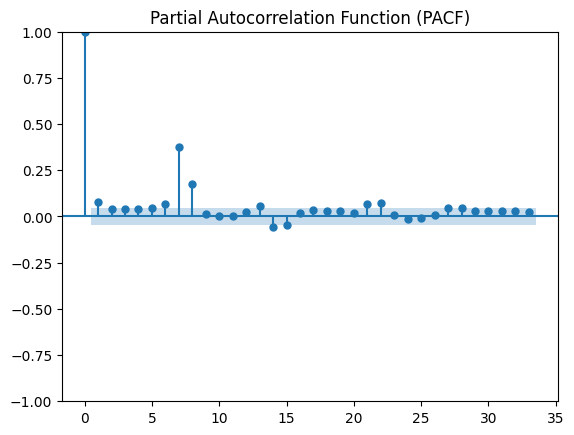

In [227]:
plot_pacf(df['unit_sales_log'])
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

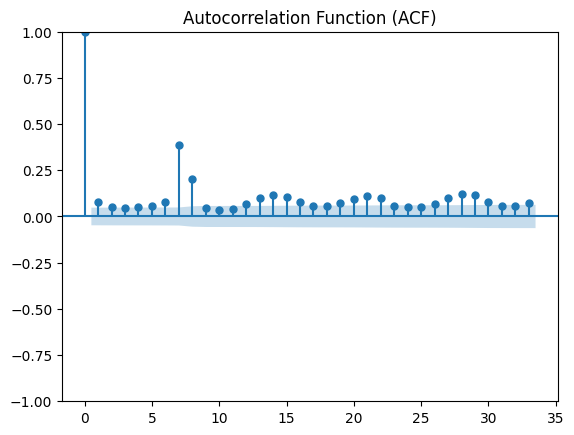

In [228]:
plot_acf(df['unit_sales_log'])
plt.title("Autocorrelation Function (ACF)")
plt.show()

/home/lavrenchuk/TS_Project_Favorita/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


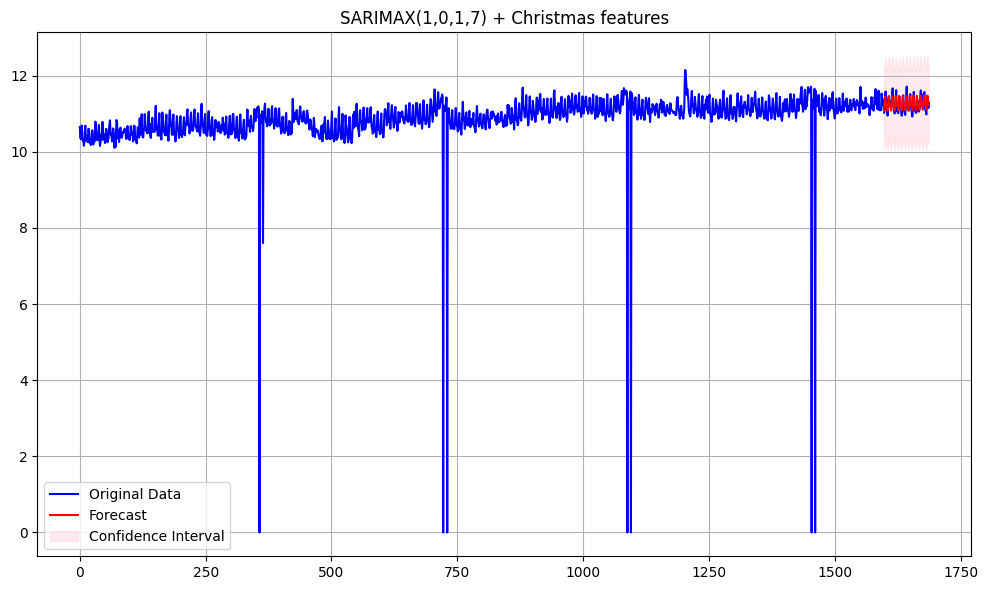

Метрики:
MAE_90  = 8537.6231
RMSE_90 = 10978.2872
MAPE_90 = 10.74%


In [229]:

#SARIMA(1,0,1)(1,0,1,7)

horizon = 90
exog = ['is_christmas', 'pre_christmas', 'post_christmas']

train = df['unit_sales_log'].iloc[:-horizon]
test  = df['unit_sales_log'].iloc[-horizon:]

train_exog = df[exog].iloc[:-horizon]
test_exog  = df[exog].iloc[-horizon:]


# SARIMAX(1,0,1)(1,0,1,7)+Christmas-features
# Визначаємо модель
mod = SARIMAX(
    train,
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7),
    exog=train_exog
)
mod_fit = mod.fit()

# Прогноз на наступні 90 днів
forecast = mod_fit.get_forecast(steps=len(test), exog=test_exog)
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Візуалізація
plt.figure(figsize=(10, 6))
plt.plot(df['unit_sales_log'], label = 'Original Data', color='blue')
plt.plot(test.index, forecast_values, label='Forecast', color='red')
plt.fill_between(test.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3,
                 label = 'Confidence Interval')

r2 = r2_score(test, forecast_values)
plt.title(f'SARIMAX(1,0,1,7) + Christmas features')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

test_orig = np.exp(test)
forecast_orig = np.exp(forecast_values)

MAE_90  = mean_absolute_error(test_orig, forecast_orig)
RMSE_90 = np.sqrt(mean_squared_error(test_orig, forecast_orig))
MAPE_90 = np.mean(np.abs((test_orig - forecast_orig) / test_orig)) * 100

print("Метрики:")
print(f"MAE_90  = {MAE_90:.4f}")
print(f"RMSE_90 = {RMSE_90:.4f}")
print(f"MAPE_90 = {MAPE_90:.2f}%")

Все ще найкраща модель з побудованих - на осномі Prophet із тижневою, річною сезонністю, а також окремими трьома змінними 'is_christmas', 'pre_christmas', 'post_christmas'.